<script src="http://d3js.org/d3.v3.min.js" charset="utf-8"></script>


## 6 事前分布をはっきりさせよう


### 主観的な事前分布と客観的な事前分布
---

#### 客観的な事前分布
未知数が取りうる値全体をカバーする分布。一様分布そのもの。ただし範囲を限定した一様分布は厳密には客観的ではない。（主観で範囲を決めている）

#### 主観的な事前分布
「未知数が0.5付近の値を取りそうだが、0や1の値は殆ど取らないだろう」などの信念を反映する。

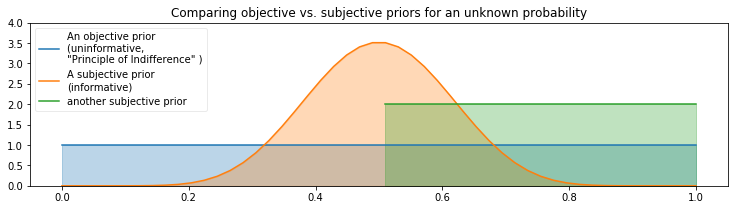

In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats

figsize(12.5, 3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0, 1)
y1, y2 = stats.beta.pdf(x, 1, 1), stats.beta.pdf(x, 10, 10)

p = plt.plot(x, y1,
             label='An objective prior \n(uninformative, \n"Principle of Indifference" )')
plt.fill_between(x, 0, y1, color=p[0].get_color(), alpha=0.3)

p = plt.plot(x, y2,
             label="A subjective prior \n(informative)")
plt.fill_between(x, 0, y2, color=p[0].get_color(), alpha=0.3)

p = plt.plot(x[25:], 2 * np.ones(25), label="another subjective prior")
plt.fill_between(x[25:], 0, 2, color=p[0].get_color(), alpha=0.3)

plt.ylim(0, 4)

plt.ylim(0, 4)
leg = plt.legend(loc="upper left")
leg.get_frame().set_alpha(0.4)
plt.title("Comparing objective vs. subjective priors for an unknown probability");

主観と客観のどちらを使うかは問題による。

### 経験ベイズ
---

頻度主義とベイズ手技を組み合わせた考え方。半客観的と言われる。  
正規分布のパラメータ$\mu$を推定する問題を考える。$\mu$の事前分布を正規分布とした場合、事前分布のハイパーパラメータ$\mu_p$の設定の仕方は。。。

#### ベイズ
観測されたデータの平均を使う。

事前分布　→　観測データ　→　事後分布

#### 経験ベイズ
観測されたデータの平均を使う。
$$
\mu_p = \frac{1}{N} \sum_{i=0}^N X_i 
$$
観測データ　→　事前分布　→　観測データ　→　事後分布

### ベイズ多椀バンディット
---

10台のスロットマシンがある。アーム（レバー）を引いたらあたりが出る確率はバンディット（スロットマシン）によって異なる。それらの確率はわからない。  
自分の勝ち分を最大化するためには、良いバンディットをできるだけ早く見抜けば良い。  
ただし、良さげなバンディットを見つけても、それを引き続けるべきか、もっと良いかもしれない他のバンディットを引いてみるべきか悩ましい。  
（探索と活用のジレンマ）


#### 解法
1. 各バンディット$b$の事前分布（確率が全くわからないので一様分布）からランダムな結果$X_b$をサンプリングする。
2. 最も高い値のサンプルを出したバンディット$B$を選択する。$B = \text{argmax}\;\; X_b$.
3. バンディット$B$の結果を観測し、バンディット$B$の事前分布を更新する。
4. 1に戻る。


In [2]:
from pymc import rbeta


class Bandits(object):

    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """

    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def pull(self, i):
        # i is which arm to pull
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)


class BayesianStrategy(object):

    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """

    def __init__(self, bandits):

        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    def sample_bandits(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the bandits's priors, and select the largest sample
            choice = np.argmax(rbeta(1 + self.wins, 1 + self.trials - self.wins))

            # sample the chosen bandit
            result = self.bandits.pull(choice)

            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [3]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)


def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +
                  "s" * (bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

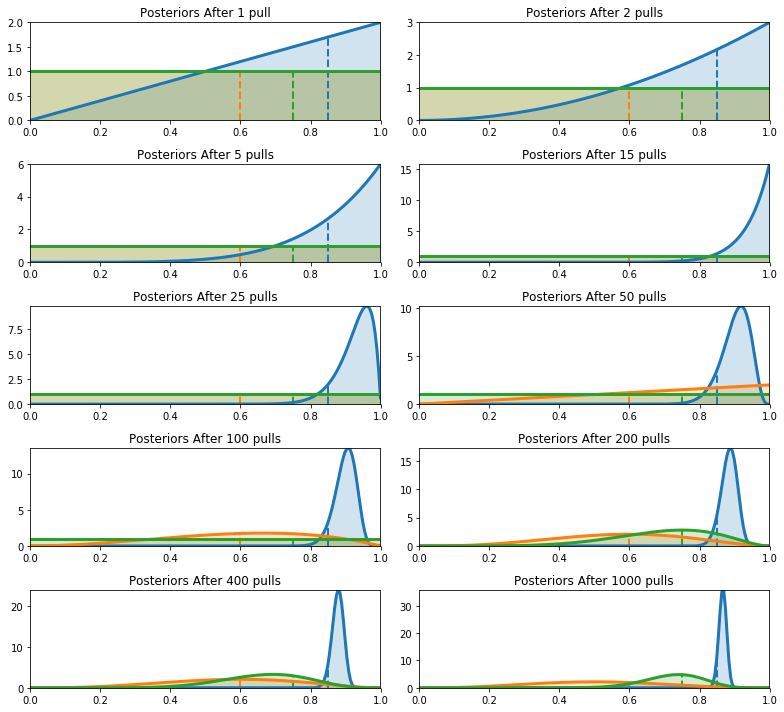

In [14]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    # plt.legend()
    plt.autoscale(tight=True)
plt.tight_layout()

#### 良さを測る

最良のバンディットのあたりの確率を$w_{opt}$とする。このバンディットを最初から引き続けれるのが最適の戦略。

取った戦略がこの最適の戦略と比較してどの程度良いのか？を測るため、戦略の全リグレットを定義する。  
これは、最適な戦略を$T$回引いた場合のリターンと、別の戦略で$T$回引いた場合の差で定義される。

\begin{align}
R_T & = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right)\\\\
& = Tw^* - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}
ここで、$w_{B(i)}$は$i$回目に選ばれたバンディットのあたりの確率。

以下の戦略の全リグレットをプロットしてみる。
1. ランダム：ランダムに選択したバンディットのアームを引く。
2. 最大ベイズ信用区間上限：推定された確率の95％信用区間の上限が最も大きいバンディットを引く。
3. ベイズ-UCBアルゴリズム：スコアが最も大きいバンディットを引く。
4. 事後分布平均：事後分布の平均が最も大きいバンディットを引く。
5. 最大観測割合：現在までに観測された当たりの割合が最も大きいバンディットを引く。

In [16]:
figsize(12.5, 5)
from other_strats import GeneralBanditStrat, bayesian_bandit_choice, max_mean, lower_credible_choice, \
                         upper_credible_choice, random_choice, ucb_bayes, Bandits

# define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

# define regret


def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

# create new strategies
strategies = [upper_credible_choice,
              bayesian_bandit_choice,
              ucb_bayes,
              max_mean,
              random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

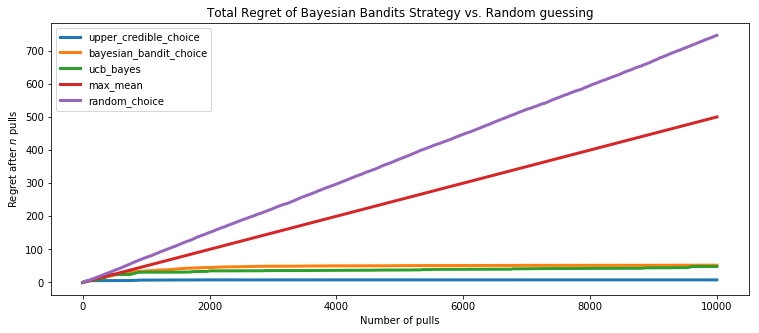

In [17]:
# train 10000 times
for strat in algos:
    strat.sample_bandits(10000)

#test and plot
for i, strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label=strategies[i].__name__, lw=3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc="upper left");

ベイズのリグレットが小さい。
1回のシミュレーションではたまたまかもしれないので、期待リグレットを評価する。

$$\bar{R_T} = E[ R_T ] $$

期待リグレットは対数的に増加することが示されている。
$$ E[R_T] = \Omega \left( \;\log(T)\; \right)$$

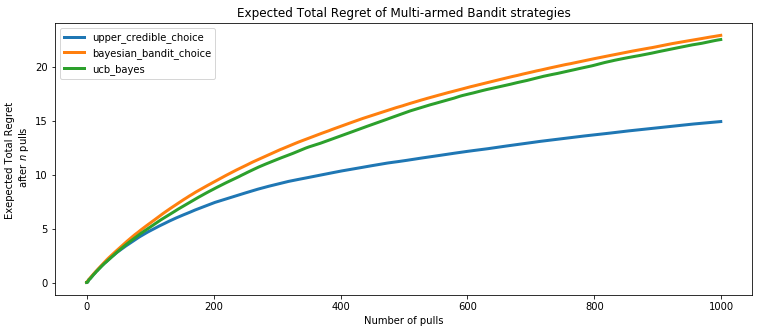

In [25]:
# this can be slow, so I recommend NOT running it.
trials = 300
expected_total_regret = np.zeros((1000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(1000)
        _regret = regret(hidden_prob, general_strat.choices)
        expected_total_regret[:, i_strat] += _regret

    plt.plot(expected_total_regret[:, i_strat] / trials, lw=3, label=strat.__name__)

plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc="upper left");

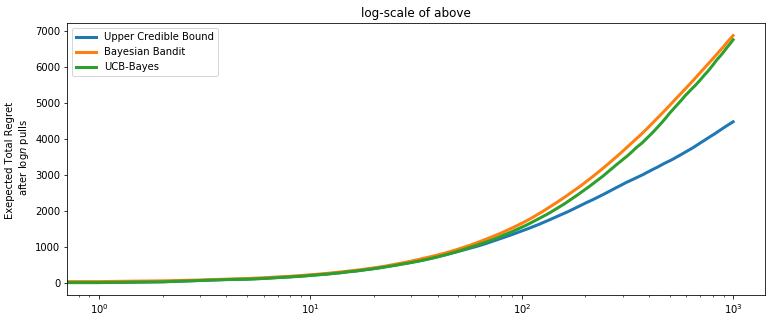

In [26]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0, 1, 2]], lw=3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3],
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
           loc="upper left")
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title("log-scale of above");
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");

### 株売買の収益
---

アップル、グーグル、テスラ、アマゾンの日次リターンを考える。ファンドマネージャーに「それぞれの会社はどのようなリターン特性をもつか？」と尋ね、その特性が正規分布に見えたとし、事前分布として正規分布を当てはめることにする。

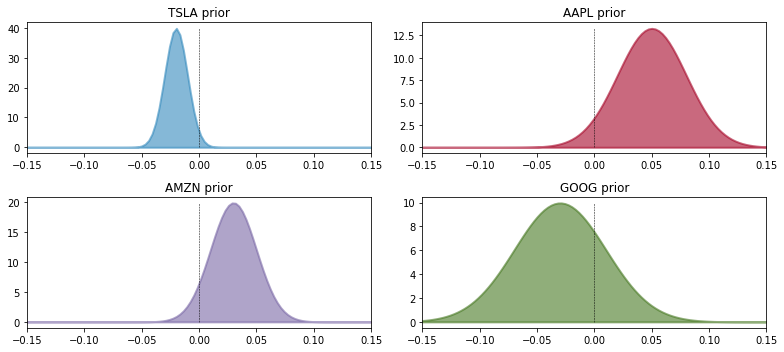

In [28]:
figsize(11., 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {"AAPL": (0.05, 0.03),
                       "GOOG": (-0.03, 0.04),
                       "TSLA": (-0.02, 0.01),
                       "AMZN": (0.03, 0.02),
                       }

for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i + 1)
    y = normal.pdf(x, params[0], scale=params[1])
    #plt.plot( x, y, c = colors[i] )
    plt.fill_between(x, 0, y, color=colors[i], linewidth=2,
                     edgecolor=colors[i], alpha=0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k", "--", linewidth=0.5)
    plt.xlim(-0.15, 0.15)
plt.tight_layout()

これらはドメイン知識が反映された主観的な事前分布である。  
これらのリターンのモデリング精度を上げるには、リターンの共分散行列を考えたほうが良い。  
（相関の高い2つの銘柄は一緒に値下がりするので同時に投資するのは良くない）  
ウィシャーと分布を使う。

In [29]:
import pymc as pm

n_observations = 100  # we will truncate the the most recent 100 days.

prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

inv_cov_matrix = pm.Wishart("inv_cov_matrix", n_observations, np.diag(prior_std ** 2))
mu = pm.Normal("returns", prior_mu, 1, size=4)

各銘柄の日次リターン

In [ ]:
# I wish I could have used Pandas as a prereq for this book, but oh well.
import datetime
import ystockquote as ysq

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = "2015-04-27"
startdate = "2012-09-01"

stock_closes = {}
stock_returns = {}
CLOSE = 6

for stock in stocks:
    x = np.array(ysq.get_historical_prices(stock, startdate, enddate))
    stock_closes[stock] = x[1:, CLOSE].astype(float)

# create returns:

for stock in stocks:
    _previous_day = np.roll(stock_closes[stock], -1)
    stock_returns[stock] = ((stock_closes[stock] - _previous_day) / _previous_day)[:n_observations]

dates = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), x[1:n_observations + 1, 0]))

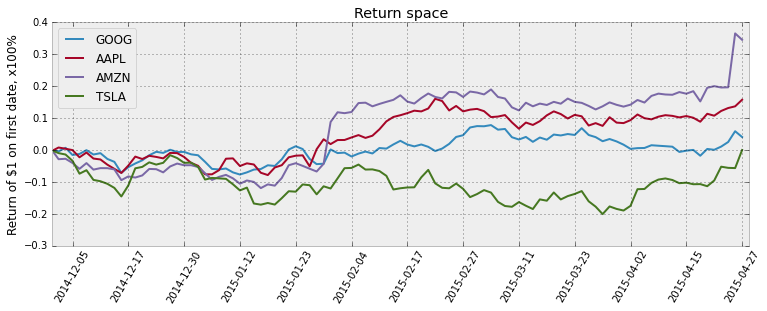

In [20]:
figsize(12.5, 4)

for _stock, _returns in stock_returns.items():
    p = plt.plot((1 + _returns)[::-1].cumprod() - 1, '-o', label="%s" % _stock,
                 markersize=4, markeredgecolor="none")

plt.xticks(np.arange(100)[::-8],
           list(map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::8])),
           rotation=60);

plt.legend(loc="upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%");

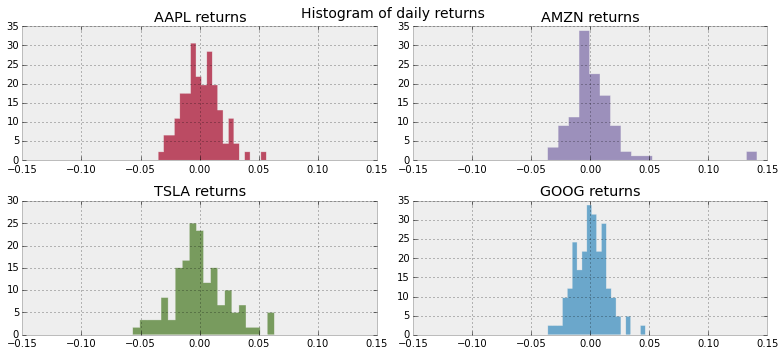

In [21]:
figsize(11., 5)
returns = np.zeros((n_observations, 4))

for i, (_stock, _returns) in enumerate(stock_returns.items()):
    returns[:, i] = _returns
    plt.subplot(2, 2, i+1)
    plt.hist(_returns, bins=20,
             normed=True, histtype="stepfilled",
             color=colors[i], alpha=0.7)
    plt.title(_stock + " returns")
    plt.xlim(-0.15, 0.15)

plt.tight_layout()
plt.suptitle("Histogram of daily returns", size=14);

事後平均と事後共分散行列を推定する。

In [ ]:
obs = pm.MvNormal("observed returns", mu, inv_cov_matrix, observed=True, value=returns)

model = pm.Model([obs, mu, inv_cov_matrix])
mcmc = pm.MCMC()

mcmc.sample(150000, 100000, 3)

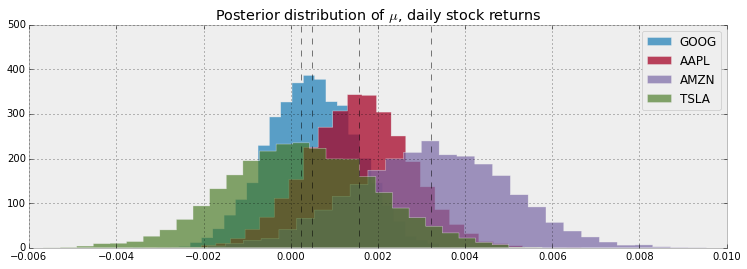

In [23]:
figsize(12.5, 4)

# examine the mean return first.
mu_samples = mcmc.trace("returns")[:]

for i in range(4):
    plt.hist(mu_samples[:, i], alpha=0.8 - 0.05 * i, bins=30,
             histtype="stepfilled", normed=True,
             label="%s" % list(stock_returns.keys())[i])

plt.vlines(mu_samples.mean(axis=0), 0, 500, linestyle="--", linewidth=.5)

plt.title("Posterior distribution of $\mu$, daily stock returns")
plt.legend();

事前分布よりも幅が狭い。事前分布と同じスケールで見ると。。。

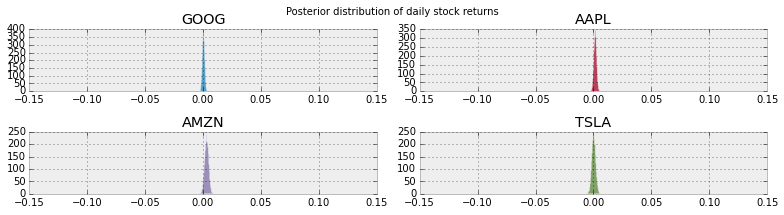

In [24]:
figsize(11.0, 3)
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(mu_samples[:, i], alpha=0.8 - 0.05 * i, bins=30,
             histtype="stepfilled", normed=True, color=colors[i],
             label="%s" % list(stock_returns.keys())[i])
    plt.title("%s" % list(stock_returns.keys())[i])
    plt.xlim(-0.15, 0.15)

plt.suptitle("Posterior distribution of daily stock returns")
plt.tight_layout()

金融データには非常にノイズが多く、このような状況下での推論は非常に困難。中立的な立場からすると、この結果をそのまま解釈することには慎重になったほうが良い。  
* ヒストグラムでは、0を中心に分布している。
* ファンドマネージャーの主観的な事前分布にも影響されている。

事後相関行列と事後分散は

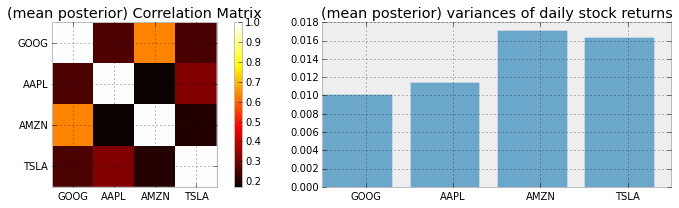

In [25]:
inv_cov_samples = mcmc.trace("inv_cov_matrix")[:]
mean_covariance_matrix = np.linalg.inv(inv_cov_samples.mean(axis=0))


def cov2corr(A):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T / d).T) / d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A


plt.subplot(1, 2, 1)
plt.imshow(cov2corr(mean_covariance_matrix), interpolation="none",
           cmap=plt.cm.hot)
plt.xticks(np.arange(4), stock_returns.keys())
plt.yticks(np.arange(4), stock_returns.keys())
plt.colorbar(orientation="vertical")
plt.title("(mean posterior) Correlation Matrix")

plt.subplot(1, 2, 2)
plt.bar(np.arange(4), np.sqrt(np.diag(mean_covariance_matrix)),
        color="#348ABD", alpha=0.7)
plt.xticks(np.arange(4) + 0.5, stock_returns.keys());
plt.title("(mean posterior) variances of daily stock returns")

plt.tight_layout();

ベイズ推論を使うと、株式相場の問題を平均・分散の最小化問題に落とし込むことができる。
この最適化の目的関数は、リターンと分散のトレードオフのバランスをとったもので、最適な重みを$w_{opt}$とおくと、最適化問題は次のようにかける。

$$ w_{opt} = \max_{w} \frac{1}{N}\left( \sum_{i=0}^N \mu_i^T w - \frac{\lambda}{2}w^T\Sigma_i w \right)$$

ここで、 $\mu_i$ と $\Sigma_i$ は平均リターンと共分散行列の$i$番目の事後推定値である。これは損失関数最適化の例でもある。

### まとめ
---

* 事前分布の使い方を再確認した。
* 事前分布はベイズ推論のメリットでもあり、デメリットでもある。
* どんなデータに対しても柔軟にモデリングできる一方、主観に左右される。
* 事前分布は慎重に選ぶ必要がある。